Data reference :
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/overview

- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost

# Business problem
<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

## Understanding and Exploring the Data

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```attributed_time```: if user download the app for after clicking an ad, this is the time of the app download
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded



In [1]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

import gc
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
train_sample = pd.read_csv("data/train_sample.csv", usecols=colnames)

In [3]:
len(train_sample.index)

100000

In [4]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


# Exploring the data

In [5]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null int64
app              100000 non-null int64
device           100000 non-null int64
os               100000 non-null int64
channel          100000 non-null int64
click_time       100000 non-null object
is_attributed    100000 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


In [6]:
def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'ip': 34857,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [7]:
train_sample.dtypes

ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

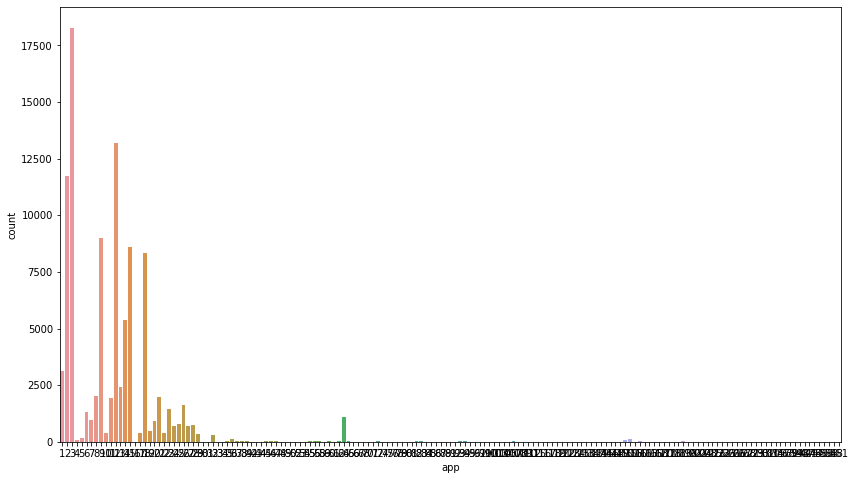

In [8]:
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)
plt.show()

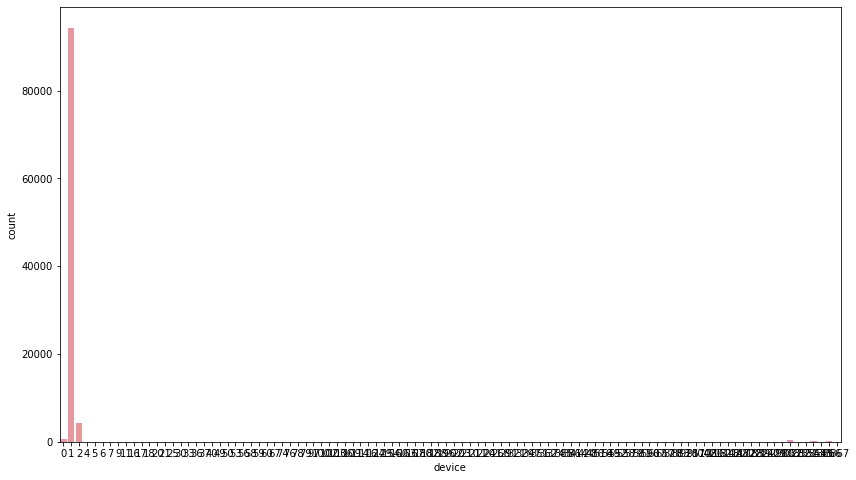

In [9]:
plt.figure(figsize=(14, 8))
sns.countplot(x="device", data=train_sample)
plt.show()

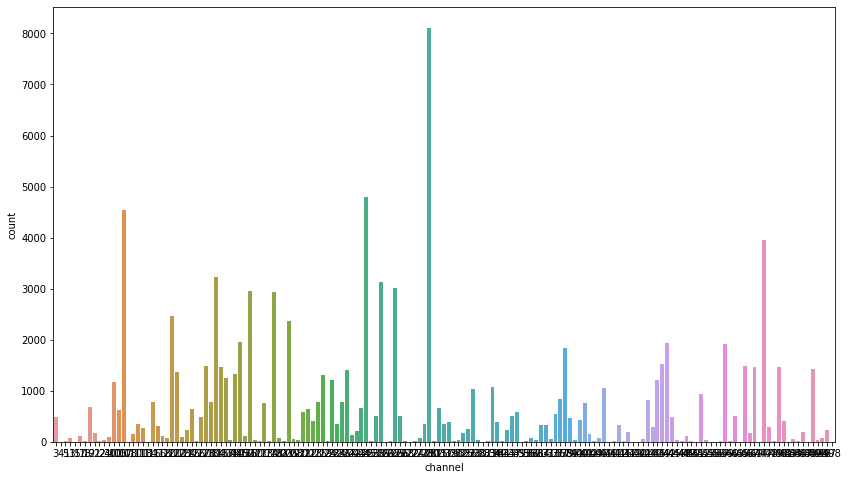

In [10]:
plt.figure(figsize=(14,8))
sns.countplot(x="channel", data=train_sample)
plt.show()

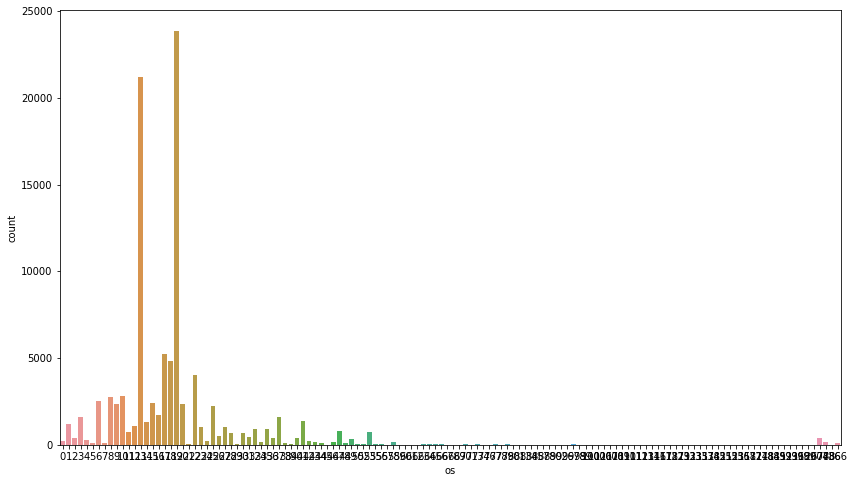

In [11]:
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)

In [12]:
# Target  Variable
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

### Exploring the Data - Segmented Univariate Analysis

Let's now look at how the target variable varies with the various predictors.

In [13]:
# plot the average of 'is_attributed', or 'download rate'
# with app 
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [14]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


In [15]:
len(frequent_apps.index)

98977

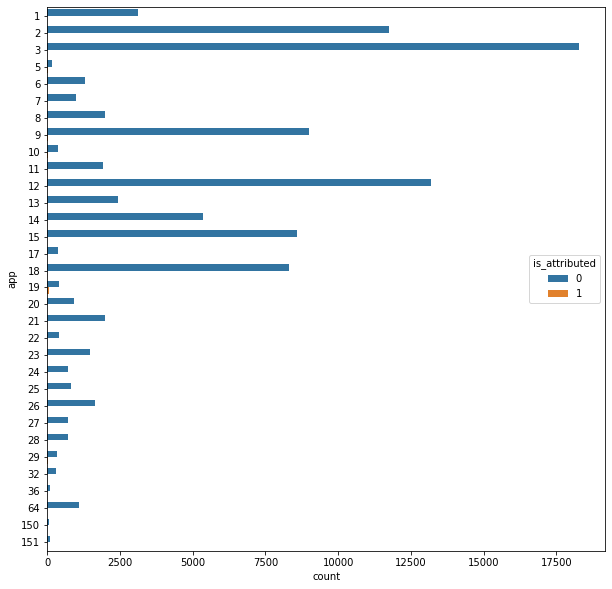

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps);

### Feature Engineering

###  Datetime based Features

In [17]:
def timeFeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    return df

In [18]:
train_sample = timeFeatures(train_sample)

In [19]:
train_sample.drop(['click_time', 'datetime'], axis =1, inplace = True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


### IP Address based Feature Engineering

In [20]:
ip_count = train_sample.groupby('ip').size().reset_index(name = 'ip_count')

In [21]:
def grouped_features(df):
    ip_count = df.groupby('ip').size().reset_index(name = 'ip_count')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour')
    ip_hour_channel = df[['ip','hour','channel']].groupby(['ip','hour','channel']).size().reset_index(name = 'ip_hour_channel')
    ip_hour_os = df.groupby(['ip','hour','os']).channel.count().reset_index(name = 'ip_hour_os')
    ip_hour_app = df.groupby(['ip','hour','app']).channel.count().reset_index(name ='ip_hour_app')
    ip_hour_device = df.groupby(['ip','hour','device']).channel.count().reset_index(name = 'ip_hour_device')
    
    df = pd.merge(df, ip_count, on = 'ip', how ='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on = ['ip','day_of_week','hour'], how = 'left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [22]:
train_sample = grouped_features(train_sample)

In [23]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,87540,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,105560,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,101424,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,94584,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,68413,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


### Modelling

In [24]:
X = train_sample.drop('is_attributed', axis = 1)
y = train_sample[['is_attributed']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 15)
(20000, 15)
(80000, 1)
(20000, 1)


In [26]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


### AdaBoost

In [27]:
tree =  DecisionTreeClassifier(max_depth = 2)
adaboost_1 = AdaBoostClassifier(base_estimator=tree,
                               n_estimators = 600,
                               learning_rate = 1.5,
                               algorithm = 'SAMME')

In [28]:
adaboost_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [29]:
predictions = adaboost_1.predict_proba(X_test)

In [30]:
predictions[:10]

array([[0.52604139, 0.47395861],
       [0.52708598, 0.47291402],
       [0.53443925, 0.46556075],
       [0.52347606, 0.47652394],
       [0.51846675, 0.48153325],
       [0.52604264, 0.47395736],
       [0.51788679, 0.48211321],
       [0.52364772, 0.47635228],
       [0.5264057 , 0.4735943 ],
       [0.51761501, 0.48238499]])

In [31]:
metrics.roc_auc_score(y_test, predictions[:,1])

0.9336206464545227

### AdaBoost - Hyperparameter Tuning

In [32]:
param_grid = {"base_estimator__max_depth" : [2,5],
             "n_estimators": [200,400,600]
             }

In [33]:
tree = DecisionTreeClassifier()

ABC = AdaBoostClassifier(base_estimator=tree,
                        learning_rate = 0.6,
                        algorithm='SAMME')

In [34]:
folds = 3
grid_search_ABC = GridSearchCV(ABC,
                              cv = folds,
                              param_grid = param_grid,
                              scoring = 'roc_auc',
                               return_train_score=True,
                               verbose = 1)

In [35]:
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                mi

In [36]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,9.339357,0.386122,0.421532,0.003293,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.950011,0.971702,0.944838,0.955517,0.011638,1,0.996576,0.995452,0.996906,0.996311,0.000622
1,17.992974,0.422524,0.811507,0.008210,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.939375,0.966682,0.944476,0.950177,0.011855,2,0.997882,0.997006,0.998171,0.997686,0.000495
2,26.649142,0.141653,1.211114,0.004024,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.934455,0.964245,0.944032,0.947578,0.012417,3,0.998218,0.997939,0.998677,0.998278,0.000305
3,18.491214,0.066834,0.469744,0.003258,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.925878,0.953901,0.943800,0.941193,0.011588,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,39.200462,0.552950,0.962768,0.003406,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.909889,0.950340,0.941778,0.934002,0.017405,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,58.468929,0.081319,1.441488,0.003303,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.915662,0.951124,0.935038,0.933941,0.014498,6,1.000000,1.000000,1.000000,1.000000,0.000000


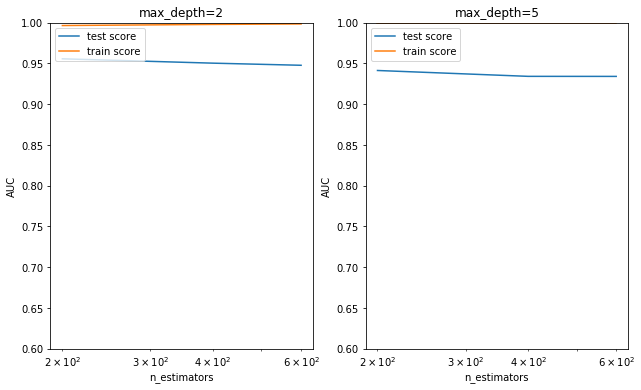

In [37]:
plt.figure(figsize = (16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    plt.subplot(1,3,n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]
    
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim((0.60,1))
    plt.legend(['test score','train score'], loc = 'upper left')
    plt.xscale('log')

In [38]:
grid_search_ABC.best_params_

{'base_estimator__max_depth': 2, 'n_estimators': 200}

In [39]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [40]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.58779945, 0.41220055],
       [0.58492178, 0.41507822],
       [0.6007091 , 0.3992909 ],
       [0.58302554, 0.41697446],
       [0.55506588, 0.44493412],
       [0.582581  , 0.417419  ],
       [0.57448009, 0.42551991],
       [0.58423414, 0.41576586],
       [0.58903589, 0.41096411],
       [0.56039353, 0.43960647]])

In [41]:
metrics.roc_auc_score(y_test, predictions[:,1])

0.9444683872045435